# Calculating g(2) using the Moku TFA

by Jason Ball
Created November 18th, 2025
Last modified December 8th, 2025

This notebook compares two methods of calculating the second-order correlation function, or g(2), accompanying the application note on the topic. 

In method 1, the Moku Time & Frequency Analyzer logs raw timestamps and calculates the full pairwise g(2) function in post-processing. 
In method 2, the Moku Time & Frequency Analyzer uses a convolutional approximation to calculate the g(2) function in real-time. These methods are then plotted together for comparison. 

In [1]:
### First we begin with our standard imports

import numpy as np
import matplotlib.pyplot as plt
import subprocess

# Then import our Moku instruments for this demo

from moku.instruments import WaveformGenerator
from moku.instruments import TimeFrequencyAnalyzer
from moku.instruments import CustomInstrument
from moku.instruments import Oscilloscope
from moku.instruments import MultiInstrument

In [3]:
### Establish connection to the Moku ###
### IP address will be different based on your setup ###
### Platform id will always be 4 for Moku Pro ###
mim = MultiInstrument('192.168.X.XXX', force_connect=True, platform_id=4)

### Retrieve the hardware version, serial number, and firmware version from the instrument ### 
idn = mim.serial_number()
prop = mim.describe()
print('Hello! I am your ' + prop['hardware'] + ' with ID ' + idn)
print('My MokuOS version is ' + str(prop['mokuOS']))

Hello! I am your Moku:Pro with ID 000054
My MokuOS version is 4.1.1


In [7]:
### We define the function we need for later.

# --- Full pairwise Cross-correlation ---
def compute_cross_g2(A_times, B_times, tau_max, bin_width, mode='unknown'):
    """Monte Carlo estimation of g2 using cross-correlation."""
    taus = []
    A_times = np.sort(A_times)
    B_times = np.sort(B_times)
    nA, nB = len(A_times), len(B_times)

    for i in range(nA):
        tA = A_times[i]
        j = np.searchsorted(B_times, tA - tau_max, side='left')
        while j < nB and B_times[j] <= tA + tau_max:
            tau = B_times[j] - tA
            if abs(tau) <= tau_max:
                taus.append(tau)
            j += 1

    taus = np.array(taus)
    print(f"\n[{mode.upper()}]")
    print(f"  Number of events at A: {nA}")
    print(f"  Number of events at B: {nB}")
    print(f"  Number of time differences (taus): {len(taus)}")

    if len(taus) == 0:
        print(f"  WARNING: no taus computed.")
        return np.linspace(-tau_max, tau_max, 10), np.zeros(9)

    bins = np.arange(-tau_max, tau_max + bin_width, bin_width)
    counts, edges = np.histogram(taus, bins=bins)
    tau_centers = (edges[:-1] + edges[1:]) / 2

    T = max(A_times[-1], B_times[-1]) - min(A_times[0], B_times[0])
    expected_counts_per_bin_per_sec = (nA * nB * bin_width) / (T ** 2)
    counts_per_sec = counts / T
    g2 = counts_per_sec / expected_counts_per_bin_per_sec

    return tau_centers, g2

In [9]:
### Set up instruments on Moku ###

wg1 = mim.set_instrument(1, WaveformGenerator)
wg2 = mim.set_instrument(2, WaveformGenerator)
tfa = mim.set_instrument(3, TimeFrequencyAnalyzer)
osc = mim.set_instrument(4, Oscilloscope)

### Define connection map ###
### The best way is to use a Python dictionary. Each connection has a source and destination. ###
### Slots are numbered 1-4, Inputs and Outputs are ordered A/B/C ###
### See the image below for reference ###

connections = [dict(source="Slot2OutA", destination="Slot4InA"),
               dict(source="Slot2OutB", destination="Slot4InB")]

mim.set_connections(connections=connections)

print('Instruments and Connections Set')

Instruments and Connections Set


In [31]:
### Set up Waveform Generator ("photon" source - use two random noise sources)

wg1.generate_waveform(channel=1, amplitude=1.0, type='Noise')
wg1.generate_waveform(channel=2, amplitude=1.0, type='Noise')

### Set up Waveform Generator ("detector" - set dead time and pulse length)

wg2.generate_waveform(channel=1, amplitude=1.0, frequency=500e3, edge_time=2e-9, pulse_width=10e-9, type='Pulse')
wg2.generate_waveform(channel=2, amplitude=1.0, frequency=500e3, edge_time=2e-9, pulse_width=10e-9, type='Pulse')
wg2.set_burst_mode(1, source='InputA', mode='NCycle', burst_cycles=1, trigger_level=0.4)
wg2.set_burst_mode(2, source='InputB', mode='NCycle', burst_cycles=1, trigger_level=0.4)

### Set up Time & Frequency Analyzer (time tagger). Instrument will record the time difference between Event A and Event B
### Set to windowed mode for 500 ms

tfa.set_event_detector(1, source="InputA", threshold=0.0)
tfa.set_event_detector(2, source="InputB", threshold=0.0)
tfa.set_interval_analyzer(1, 1, 2)
tfa.set_acquisition_mode(mode='Windowed', window_length=0.5)

### Set up Oscilloscope. Start with a timebase of 100 us and a standard rising edge trigger

osc.set_timebase(-50e-6, 50e-6)
osc.set_trigger(type="Edge", source="ChannelA", level=0.5)

print('Instruments configured. Ready to measure')

WG, CI, TFA, OSC configured


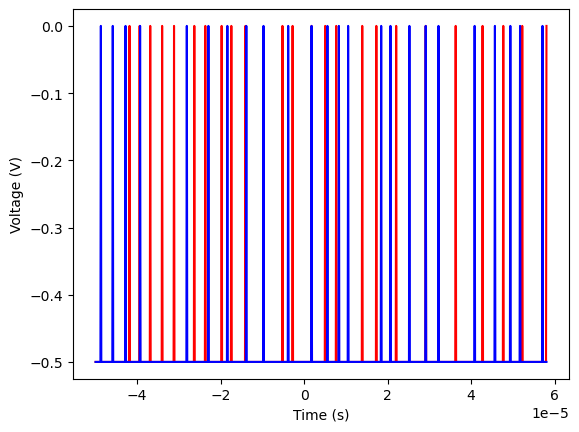

In [33]:
### Verify that the system is working properly
### Take an Oscilloscope trace 

time_series_data = osc.get_data(wait_complete=True)

### Plot the Oscilloscope data. We should see a series of "TTL" pulses) 
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (V)')
ax.plot(time_series_data['time'], time_series_data['ch1'], 'r', label='ChA')
ax.plot(time_series_data['time'], time_series_data['ch2'], 'b', label='ChAB')

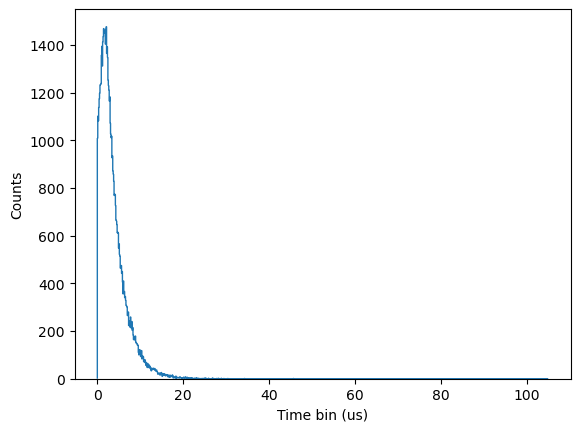

In [53]:
### Now let's look at the histogram generated by the Time & Frequency Analyzer 
### Grab the standard histogram, not g(2) yet
tfa.set_histogram(start_time=0, stop_time=100e-6)
histogram_data = tfa.get_data()

### Prepare the histogram data so it can be plotted 
counts = histogram_data['interval1']['histogram']['data']
dt = histogram_data['interval1']['histogram']['dt']
t0 = histogram_data['interval1']['histogram']['t0']
length = len(counts)
bins =  np.linspace(start=t0, stop=t0 + dt * length, num=length+1)

### Plot histogram of first-order events
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('Time bin (us)')
ax.set_ylabel('Counts')
ax.stairs(counts, bins*1e6)

In [57]:
### We collect another window, but this time collect the raw timestamps
### This is a NEW data set, but should look qualitatively similar for a Poissonian noise source
### Start logger
result = tfa.start_logging(event_ids=[2], duration=0.5)
file_name = result['file_name']

### Download logged data from the Moku:Pro SSD
mim.download("ssd", file_name, local_path=f"/Users/jasonball/Desktop/{file_name}")

In [59]:
### Use MokuCLI to convert the file from .li format to .npy for use here 
### Change the doanload location as you wish
subprocess.check_output(['mokucli', 'convert', f"/location/{file_name}", '--format=npy'])

b'[===========================================================================]\nDone.\n'

In [61]:
### Load the logged data 
### Replace the string to match the location you specified earlier
data = np.load(f"/location/{file_name[:-3]}.npy")

A_times = []
B_times = []
### remove last X points 
trim = 2 

### Sort event timestamps and place them into two arrays
for x in range(0,len(data)):
    if data[x][0] == 1:
        A_times.append(data[x][1])
    else:
        B_times.append(data[x][1])
## Same
if trim == 0:
    A_times = np.array(A_times)
    B_times = np.array(B_times)
else:
    A_times = np.array(A_times[:-trim])
    B_times = np.array(B_times[:-trim])
# calculate times of correlated pairs (A, followed by B) 
T = (B_times[-1] - B_times[0])

In [4]:
# Specify the maximum tau and bin width used in g(2) calculation.
# This does not strictly have to match that of the Moku, but we use the same parameters for accurate comparison 
tau_max = 100e-6
bin_width = dt #same bin wisth as histogram 
num_bins = int(tau_max / bin_width)

NameError: name 'dt' is not defined

In [65]:
# Gather histogram again, but this time record g(2)
tfa.set_histogram(start_time=0, stop_time=tau_max, type='G2')
histogram_data = tfa.get_data()

# Prepare data for plotting like we did previously 
counts = histogram_data['interval1']['histogram']['data']
dt = histogram_data['interval1']['histogram']['dt']
t0 = histogram_data['interval1']['histogram']['t0']
length = len(counts)
bins =  np.linspace(start=t0, stop=t0 + dt * length, num=length)


[UNKNOWN]
  Number of events at A: 20270
  Number of events at B: 20186
  Number of time differences (taus): 805484


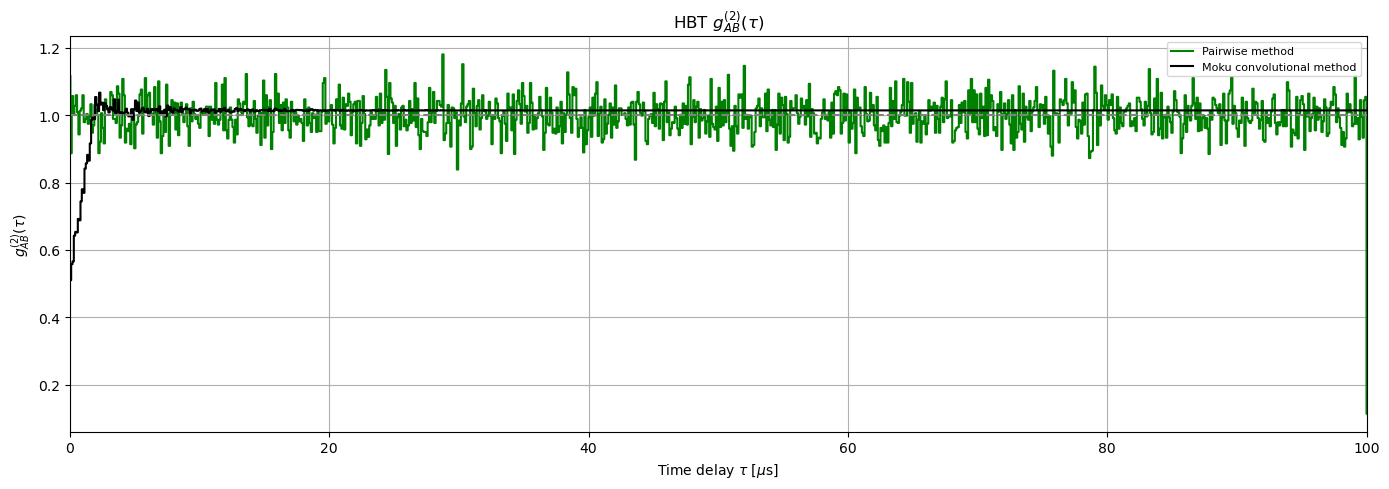

In [67]:
# Compute the cross correlation data using the timestamp data
taus, g2 = compute_cross_g2(A_times, B_times, tau_max, bin_width)

# Create a plot to compare pairwise and convolutional methods 
fig, ax1 = plt.subplots(1, 1, figsize=(14, 5))

# Add everything to the plot 
### plot pairwise method
ax1.plot(taus * 1e6, g2, drawstyle='steps-mid', label="Pairwise method", color='g', alpha=1)
### plot convolutional method 
ax1.plot(bins * 1e6, counts, drawstyle='steps-mid', label="Moku convolutional method", color='k', alpha=1)
ax1.set_xlabel(r"Time delay $\tau$ [$\mu$s]")
ax1.set_ylabel(r"$g^{(2)}_{AB}(\tau)$")
ax1.set_title(r"HBT $g^{(2)}_{AB}(\tau)$")
ax1.axhline(1, color='gray', linestyle='--', alpha=1)
ax1.legend(fontsize=8, loc='upper right')
ax1.grid(True)
ax1.set_xlim(0, tau_max * 1e6 / 1)

plt.tight_layout()
plt.savefig("g2_two_panels.pdf", bbox_inches='tight')
plt.show()